In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import esutil, scipy
sys.path.append('../')
from utils import *
from cmass_modules import io, Cuts
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def z_gaussian(mu, sigma, bins):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

def z_gaussians(A, bins):

    sigma1 = 0.07
    sigma2 = 0.2
    mu1 = 0.59
    mu2 = 0.35
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu2)**2 / (2 * sigma2**2))
    
    return A*g1 + (1.0-A) * g2

In [5]:
def log_interp(x, y):
    """
    Log interpolation
    """
    s = scipy.interpolate.interp1d(log(x), log(y))
    x0 = x[0]
    y0 = y[0]
    x1 = x[-1]
    y1 = y[-1]

    def interpolator(xi):
        w1 = xi == 0
        w2 = (xi > 0) & (xi <= x0)
        w3 = xi >= x1
        w4 = ~ (w1 | w2 | w3)

        y = np.zeros_like(xi)
        y[w2] = y0 * (x0 / xi[w2])
        y[w3] = y1 * (x1 / xi[w3])**3
        y[w4] = exp(s(log(xi[w4])))
        return y
    return interpolator

def interp_2d( x, y, z):
    f = scipy.interpolate.interp2d(x, y, z, kind='cubic')
    return f

def cl_to_w(ell, c_ell, theta):
    """
    Fourier transform
    # theta unit : degree
    """
    theta = np.radians(theta)
    cl_interp = log_interp(ell, c_ell)
    ell_max = int(ell.max())
    ell_max_integral = 200000
    ell_sample = np.arange(ell_max_integral) * 1.0
    c_ell_sample = np.zeros(ell_max_integral)
    c_ell_sample = cl_interp(ell_sample)
#    for i,ell_i in enumerate(ell_sample):
#        c_ell_sample[i] = cl_interp(ell_i)

    f = (2 * ell_sample + 1) / (4 * pi)
    w = np.zeros_like(theta)
    for i, t in enumerate(theta):
        p_ell, _ = scipy.special.lpn(ell_max_integral - 1, cos(t))
        w[i] = (f * p_ell * c_ell_sample).sum()
    return w

In [153]:
zbin,dz = np.linspace(0.0,10., 1001, retstep=True)
zcenter = zbin[:-1]+dz/2.
#Nz = np.column_stack(( zbin[:-1], N1, N2, N3, N4 ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz', Nz)
Nz = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/twomass.nz')
#Nz_cmass,_ = np.histogram( cmass_spec['Z'], bins=zbin, normed=True)
#Nz_cmass = np.column_stack(( zbin[:-1], Nz_cmass ))

Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/cmass_ngc.nz')
#Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/dmass_ansatz_a0.07.nz')
N_2mass_all = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/twomass_1bin.nz')

def Pnz(z, i):
    from scipy.interpolate import interp1d
    zcenter = np.insert( Nz[:,0] + 0.005, 0, 0)
    nz = np.insert( Nz[:, i], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)

def Pnz_2mass_1bin(z, i):
    from scipy.interpolate import interp1d
    zcenter = np.insert( N_2mass_all[:,0] + 0.005, 0, 0)
    nz = np.insert( N_2mass_all[:, 1], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)


def Pnz_cmass(z, i):
    from scipy.interpolate import interp1d
    zcenter = np.insert( Nz_cmass[:,0] + 0.005, 0, 0)
    nz = np.insert( Nz_cmass[:, 1], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)

def Pnz_dmass(z, i, A=0.07):  
    """
    Two Gaussian Mixture
    A*G1 + (1-A)*G2
    """
    
    """
    
    sigma1 = 0.07
    sigma2 = 0.18
    mu1 = 0.59
    mu2 = 0.4
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu2)**2 / (2 * sigma2**2))
    return A*g1 + (1.0-A) * g2
    """    

    sigma1, sigma2, sigma3 = 0.03, 0.07, 0.2
    mu1, mu2, mu3 = 0.5, 0.56, 0.5
    #amp1, amp2, amp3 = A, 4*A, (1-A-4*A-0.07)
    amp1, amp2, amp3 = (1-A)*1./7, (1-A)*6./7, A
    
    g1 = amp1*( 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu1)**2 / (2 * sigma1**2)))
    g2 = amp2*(1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu2)**2 / (2 * sigma2**2)))
    g3 = amp3*(1./(sigma3 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu3)**2 / (2 * sigma3**2)))
    
    #g4 = 0.07*(1./(sigma3 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu3)**2 / (2 * sigma3**2)))
    
    return g1+g2+g3
    

def _Pnz_dmass(z, i, A=0.8):  
    """
    Two Gaussian Mixture
    A*G1 + (1-A)*G2
    """
    sigma1 = 0.07
    sigma2 = 0.18
    mu1 = 0.59
    mu2 = 0.4
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu2)**2 / (2 * sigma2**2))
    
    pnzdistr = np.zeros(z.size)
    mask = (z<=0.4)
    
    g2[z<0.4] = Nz_cmass04
    
    #pnzdistr[mask] = A * Pnz_cmass(z, 1)[mask]
    #pnzdistr[z > 0.4] = g1[z > 0.4]
    return A*g1 + (1.0-A) * g2
    #return pnzdistr

In [87]:
from numpy import log, exp, cos, pi

def chi(a):
    return results.comoving_radial_distance(1./a -1.)/coverH0 * h0

def Ea(a):
    return results.hubble_parameter(1./a - 1.) * 1./pars.H0
    
def Wgal_2mass(a, indz):
    """
    2MASS kernel
    """
    z = 1./a -1.
    b_avg = [1.62, 1.52, 1.54, 1.65]
    wgal  = b_avg[indz-1] * Pnz(z, indz) * Ea(a)
    return wgal

def Wgal_2mass_1bin(a):
    """
    2MASS kernel
    """
    z = 1./a -1.
    b_avg_tot = 1.5927021517080193
    wgal  = b_avg_tot * Pnz_2mass_1bin(z, 1) * Ea(a)
    return wgal


def b_cmass(z):
    bc = np.zeros(z.size)
    bc[z < 0.4] = 1.6
    bc[(z>=0.4) & (z < 0.45)] = 1.9
    bc[z >= 0.4] = 2.0
    return bc
    
def Wgal_cmass(a, indz):
    """
    cmass kernel
    """
    z = 1./a -1.
    #b_cmass = [2.0, 2.0, 2.0, 2.0]
    wgal  = b_cmass(z) * Pnz_cmass(z, 1) * Ea(a)
    return wgal
    #return 1.

def Wgal_dmass(a, indz, A=0.8):
    """
    dmass kernel
    Assume b = 2.0 for all z range.
    """
    z = 1./a -1.
    #b_cmass = [2.0, 2.0, 2.0, 2.0]
    wgal  = b_cmass(z) * Pnz_dmass(z, 1, A = A) * Ea(a)
    return wgal

def dchi_da(a):
    return 1./Ea(a)/a**2

def Pdelta(k, a):
    k = k/coverH0
    return PK.P(1./a -1., k)/(coverH0)**3

def int_for_Cl(ell, a, indz):
    
    k =  (ell+0.5) *1./chi(a)
    Pm =  np.array([Pdelta(k[i], a[i]) for i in range(k.size)])
    return Wgal_2mass(a,indz) * Wgal_2mass(a,indz) * dchi_da(a)/chi(a)**2 * Pm
 
def C_ell( ell, indz ):
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
        
    Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return Cl


def w_matter(theta, a):
    
    ellbin = np.logspace(np.log10(1e-2), np.log10(100000), 400)
    
    k =  (ellbin+0.5) *1./chi(a)
    Pm = Pdelta(k,a)
    
    w = cl_to_w(ellbin, Pm, theta)
    return w


def w_matter_interp(theta):
    
    zmin = 0.0001
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 50, retstep = True)
    #acenter = abin[:-1] + da/2.
           
    wprojt = np.array([w_matter(theta, a) for a in abin])
    wprojt_interp = interp_2d(theta, abin, wprojt)
    return wprojt_interp
    
    
def w_project( theta, w_matter_interp, indz ):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel
    """
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
    
    wprojt = w_matter_interp(theta, acenter)  #np.array([w_matter(theta, a) for a in acenter])
    int_for_res = Wgal_2mass(acenter,indz) * Wgal_cmass(acenter,indz) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)

def w_project_1bin( theta, w_matter_interp, indz ):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel 1bin
    """
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
    
    wprojt = w_matter_interp(theta, acenter)  #np.array([w_matter(theta, a) for a in acenter])
    int_for_res = Wgal_2mass_1bin(acenter) * Wgal_cmass(acenter,1) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def w_project_A( theta, w_matter_interp, indz, A=0.8 ):
    """
    w(theta) for varying A in dmass nz ansatz
    Default kernel is 2MASS kernel*DMASS kernel
    """
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
           
    #wprojt = np.array([w_matter(theta, a) for a in acenter])
    wprojt = w_matter_interp(theta, acenter) 
    int_for_res = Wgal_2mass(acenter,indz) * Wgal_dmass(acenter,indz, A=A) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def w_project_A_1bin( theta, w_matter_interp, indz, A=0.8 ):
    """
    w(theta) for varying A in dmass nz ansatz
    Default kernel is 2MASS kernel*DMASS kernel
    """
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
           
    #wprojt = np.array([w_matter(theta, a) for a in acenter])
    wprojt = w_matter_interp(theta, acenter) 
    int_for_res = Wgal_2mass_1bin(acenter) * Wgal_dmass(acenter,1, A=A) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def dw(a, indz):
    return Wgal_2mass(a, indz)* Wgal_cmass(a, indz) *dchi_da(a)/chi(a)**2 * w_matter(theta, a)

In [186]:
def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def Hartrap_factor(Nr, Nbin):
    return (Nr-Nbin-2) *1./(Nr-1)

def fitting_chisquare_cmass(indz, modelv_interp, datav_filename=None):

    meanr, datav, _ = np.genfromtxt(datav_filename, unpack=True)
    #meanr = meanr[1:]
    #datav = datav[1:]
    cov = np.loadtxt(datav_filename.split('.txt')[0]+'.cov') #[1:,1:]
    covinv = np.linalg.inv(cov)
    
    HF = Hartrap_factor(100, meanr.size)
    #Ass = np.linspace(0.8, 1.0, 50000)
    Ass = np.linspace(-0.5, 1.0, 50000)
    
    i=0
    chi2 = np.zeros(Ass.size)
    for A in Ass : 
        modelv = modelv_interp[indz](meanr, A)
        vdiff = (datav - modelv)
        chi2[i] = np.dot(np.dot( vdiff, HF*covinv ), vdiff)
        #chi2.append(res)
        i+=1
    
    chi2_min = chi2.min()
    #ind = chi2.argmin() #np.argmin(chi2)
    #Abest = Ass[ind]
    print chi2_min
    
    fig, ax = plt.subplots()
    ax.plot(Ass, chi2)
    
    A1, Amin, A2 = find_nearest( chi2, chi2_min + 1, Ass )
    errA = np.abs(Amin - A1)
    #print 'bestfit A= {:0.4f}'.format(Ass[ind]), 'errA={:0.4f}'.format(1./np.sqrt(chi2[ind])), ' chi2=', chi2[ind], ' chi2_redx=', chi2[ind]/vdiff.size
    print 'A1, Abest, A2', A1, Amin, A2
    print 'bestfit A= {:0.4f}'.format(Amin), 'errA={:0.4f}'.format(errA), ' chi2=', chi2_min



    #ax.axvline(x=Amin-errA)
    #ax.axvline(x=Amin+errA)
    #ax.set_xlabel('A')
    
    #return Ass[ind], 1./np.sqrt(chi2[ind])
    return Amin, errA, chi2



# 2MASS true redshift 

NYU value added catalog 

In [89]:
nyu_cat = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_catalog.fits')
sdss_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_sdss_spectro.fits')
twomass_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_twomass.fits')

In [90]:
cmass_spec = esutil.io.read('/n/des/lee.5922/data/cmass_cat/galaxy_DR12v5_CMASS_South.fits.gz')

In [91]:
#Nz = np.column_stack(( zbin[:-1], N1, N2, N3, N4 ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz', Nz)
#Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/cmass_ngc.nz')

Nz_cmass04,_ = np.histogram( cmass_spec['Z'], bins=np.linspace(0,0.4, 41) , normed=True)
#Nz_cmass = np.column_stack(( zbin[:-1], Nz_cmass ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/cmass_ngc.nz', Nz_cmass)

#zbin = np.linspace(0,10.0, 1001)
#Nz_dmass_bestfit = Pnz_dmass(zcenter,1 ,A=0.1)
#Nz_dmass = np.column_stack(( zbin[:-1], Nz_dmass_bestfit ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/dmass_ansatz_a0.07.nz', Nz_dmass)



#Nz_cmass_sgc,_ = np.histogram( cmass_spec['Z'], bins=zbin, normed=True)
#Nz_cmass = np.column_stack(( zbin[:-1], Nz_cmass_sgc ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/cmass_sgc.nz', Nz_cmass)


Luminosity bin mask

In [141]:
mask_k1 = (twomass_spec['K_M_K20FE'] > 12.0) & (twomass_spec['K_M_K20FE'] < 12.5)#& (sdss_spec['Z'] > 0.0001)
mask_k2 = (twomass_spec['K_M_K20FE'] > 12.5) & (twomass_spec['K_M_K20FE'] < 13.0)# & (sdss_spec['Z'] > 0.0001)
mask_k3 = (twomass_spec['K_M_K20FE'] > 13.0) & (twomass_spec['K_M_K20FE'] < 13.5)# & (sdss_spec['Z'] > 0.0001)
mask_k4 = (twomass_spec['K_M_K20FE'] > 13.5) & (twomass_spec['K_M_K20FE'] < 14.0)# & (sdss_spec['Z'] > 0.0001)

In [142]:
tot = np.sum(mask_k1)+np.sum(mask_k2)+np.sum(mask_k3)+np.sum(mask_k4)

In [143]:
print 'The fraction of sample in each luminosity bin'
print np.sum(mask_k1)*1./tot
print np.sum(mask_k2)*1./tot
print np.sum(mask_k3)*1./tot
print np.sum(mask_k4)*1./tot

The fraction of sample in each luminosity bin
0.0625966268446943
0.12674982431482784
0.26231553056921997
0.5483380182712579


In [144]:
print 'mean bias for each luminosity bin'
b_avg = [1.62, 1.52, 1.54, 1.65]
print b_avg

mean bias for each luminosity bin
[1.62, 1.52, 1.54, 1.65]


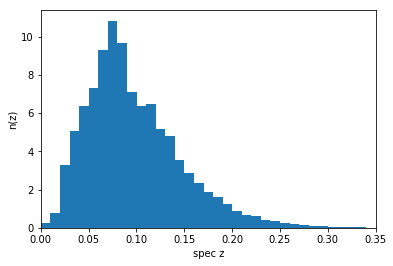

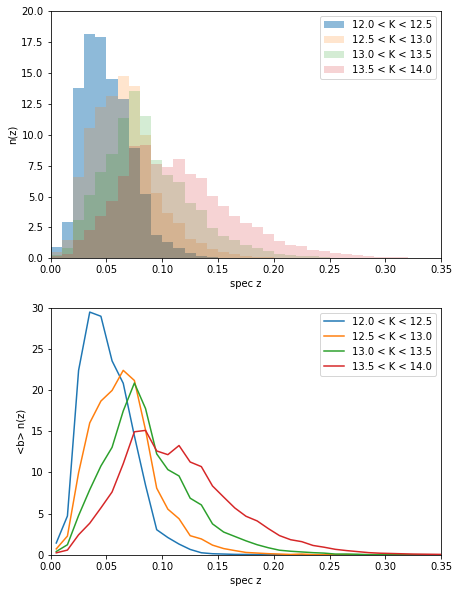

In [151]:
#zbin, dz = np.linspace(0.0001, 10.0, 1001, retstep=True)
#zcenter = zbin[:-1] + dz/2.

mask_k = (mask_k1 |mask_k2 |mask_k3 |mask_k4 )
fig, ax = plt.subplots()
N_all, _,_ = ax.hist( sdss_spec['Z'][mask_k], bins=zbin, normed=True)
ax.set_xlabel('spec z')
ax.set_ylabel('n(z)')
ax.set_xlim(0, 0.35)
#ax.set_ylim(0,20)

fig, (ax, ax2) = plt.subplots(2,1,figsize = (7,10))
N1,_, _ = ax.hist( sdss_spec['Z'][mask_k1], bins=zbin, alpha = 0.5, normed=True, label = '12.0 < K < 12.5')
N2,_, _ = ax.hist( sdss_spec['Z'][mask_k2], bins=zbin, alpha = 0.2, normed=True, label = '12.5 < K < 13.0')
N3,_, _ = ax.hist( sdss_spec['Z'][mask_k3], bins=zbin, alpha = 0.2, normed=True, label = '13.0 < K < 13.5')
N4,_, _ = ax.hist( sdss_spec['Z'][mask_k4], bins=zbin, alpha = 0.2, normed=True, label = '13.5 < K < 14.0')
ax.legend()
ax.set_xlabel('spec z')
ax.set_ylabel('n(z)')
ax.set_xlim(0, 0.35)
ax.set_ylim(0,20)

ax2.plot( zbin[:-1] + 0.005, b_avg[0] *N1, label = '12.0 < K < 12.5')
ax2.plot( zbin[:-1] + 0.005, b_avg[1] *N2, label = '12.5 < K < 13.0')
ax2.plot( zbin[:-1] + 0.005, b_avg[2] *N3, label = '13.0 < K < 13.5')
ax2.plot( zbin[:-1] + 0.005, b_avg[3] *N4, label = '13.5 < K < 14.0')
ax2.set_xlabel('spec z')
ax2.set_ylabel('<b> n(z)')
ax2.set_xlim(0, 0.35)
ax2.set_ylim(0,30)
ax2.legend()

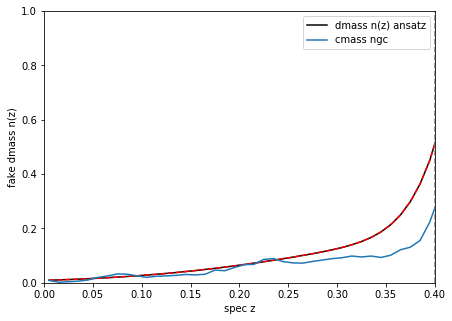

In [156]:
#zbin, dz = np.linspace(0.0, 10.0, 1001, retstep=True)



A = 0.1

A3 = 0.1
A1 = (1-A3)/7.
A2 = A1*6
G3 = A3*z_gaussian(0.5, 0.2, zcenter)
G1 = A1*z_gaussian(0.5, 0.03, zcenter)
G2 = A2*z_gaussian(0.56, 0.07, zcenter)

#G4 = 0.07*z_gaussian(0.5, 0.2, zcenter)
#G4 = 0.1*z_gaussian(0.4, 0.3, zcenter)

fig, ax = plt.subplots(1,1,figsize = (7,5))

ax.plot(zcenter, Pnz_dmass(zcenter,1 ,A=A), 'k-', label = 'dmass n(z) ansatz')
#ax.plot(zcenter, G1, 'r--')
#ax.plot(zcenter, G2, 'r--')
#ax.plot(zcenter, G3, 'r--')
ax.plot(zcenter, G1+G2+G3, 'r--')
#ax.plot(zcenter, a, 'k-', label = 'dmass n(z) ansatz')

#ax.plot(zcenter, (1.-A)*z_gaussian(0.4, 0.3, zcenter), 'r--')
ax.plot(zcenter, Pnz_cmass(zcenter,1), label = 'cmass ngc')
#N_cmass,_, _ = ax.hist( cmass_spec['Z'], bins=zbin, alpha = 0.5, normed=True, label = 'cmass ngc')
ax.axvline(x = 0.4, color='grey', linestyle='--')

dmass_frac = scipy.integrate.simps(Pnz_dmass(zcenter, 1, A = A)[:40], dx = dz )*100
cmass_frac = scipy.integrate.simps(Pnz_cmass(zcenter, 1)[:40], dx = dz )*100

#ax.text(0.02, 3, ' fraction of sample at z < 0.4 \n - cmass : {:0.2f}% \n - dmass : {:0.2f}%'\
#        .format(cmass_frac, dmass_frac), fontsize = 15)
ax.set_xlabel('spec z')
ax.set_ylabel('fake dmass n(z)')
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 1.0)
ax.legend(loc='best')

In [1]:
import camb
from camb import model, initialpower

In [10]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=68.81, ombh2=0.0221, omch2 =0.1169, omk=0.0, YHe = 0.245341, tau = 0.08,
                   num_massive_neutrinos = 1)
pars.set_dark_energy()
pars.InitPower.set_params(As=2.26e-9, ns=0.96)
results = camb.get_results(pars)

#units
cc = 299792.5
H0 = 100 
coverH0 = cc/H0
h0 = pars.H0/100.

# matter power spectrum interpolation
PK = camb.get_matter_power_interpolator\
(pars, zmin=0, zmax=10, nz_step = 101, nonlinear=True, 
 hubble_units=True, k_hunit=True, kmax=1000, log_interp = True)
    

### cmass vs 2mass forecast

In [178]:
theta = np.logspace(np.log10(0.5/60), np.log10(300./60), 100, endpoint=True)
theta = theta[:-1]*np.sqrt(theta[1]/theta[0])

In [179]:
w_matter_2d_interp = w_matter_interp(theta)

In [180]:
wproj1 = w_project(theta, w_matter_2d_interp, 1)
wproj2 = w_project(theta, w_matter_2d_interp, 2)
wproj3 = w_project(theta, w_matter_2d_interp, 3)
wproj4 = w_project(theta, w_matter_2d_interp, 4)

wproj_1bin = w_project_1bin(theta, w_matter_2d_interp, 1)

In [185]:
#As = np.linspace(0.8, 1.0, 1001)
As = np.linspace(-0.5, 1.0, 501)
modelv_dat1 = []
modelv_dat2 = []
modelv_dat3 = []
modelv_dat4 = []
modelv_1bin = []
i = 0
for A in As :
    print i,'\r' ,
    modelv_dat1.append( w_project_A( theta, w_matter_2d_interp, 1,  A=A ) )
    modelv_dat2.append( w_project_A( theta, w_matter_2d_interp, 2,  A=A ) )
    modelv_dat3.append( w_project_A( theta, w_matter_2d_interp, 3,  A=A ) )
    modelv_dat4.append( w_project_A( theta, w_matter_2d_interp, 4,  A=A ) )
    modelv_1bin.append( w_project_A_1bin(theta, w_matter_2d_interp, 1, A =A))
    i += 1

modelv_dat1 = np.array(modelv_dat1)
modelv_dat2 = np.array(modelv_dat2)
modelv_dat3 = np.array(modelv_dat3)
modelv_dat4 = np.array(modelv_dat4)
modelv_dat_1bin = np.array(modelv_1bin)

In [187]:
modelv1_interp = interp_2d( theta, As, modelv_dat1)
modelv2_interp = interp_2d( theta, As, modelv_dat2)
modelv3_interp = interp_2d( theta, As, modelv_dat3)
modelv4_interp = interp_2d( theta, As, modelv_dat4)

modelv_interp = [0, modelv1_interp, modelv2_interp, modelv3_interp, modelv4_interp]

modelv_1bin_interp = interp_2d( theta, As, modelv_dat_1bin)
modelv_1bin_interp = [modelv_1bin_interp]

In [183]:
import numpy as np
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
def eigenstats(x):
    print np.linalg.eigvals(x).min(), np.linalg.eigvals(x).max()
    print np.linalg.eigvals(x).min()/np.linalg.eigvals(x).max()

5.861593104638695
A1, Abest, A2 -0.42787855757115145 -0.18064361287225744 0.06659133182663657
bestfit A= -0.1806 errA=0.2472  chi2= 5.861593104638695
4.097462980546175
A1, Abest, A2 -0.14440288805776114 0.02663053261065218 0.1976639532790656
bestfit A= 0.0266 errA=0.1710  chi2= 4.097462980546175
5.292114426194676
A1, Abest, A2 -0.013270265405308124 0.11792235844716892 0.24911498229964602
bestfit A= 0.1179 errA=0.1312  chi2= 5.292114426194676
6.197898190285781
A1, Abest, A2 0.10433208664173288 0.2079241584831697 0.3115162303246065
bestfit A= 0.2079 errA=0.1036  chi2= 6.197898190285781


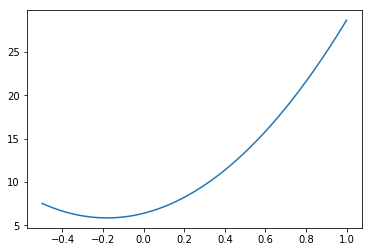

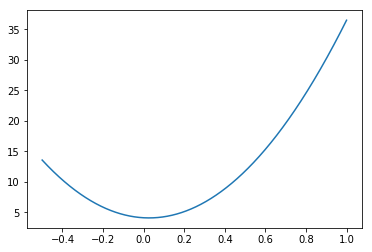

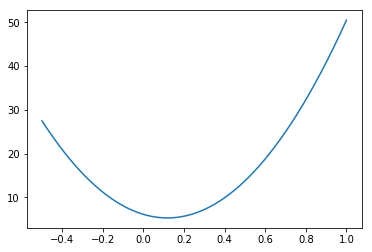

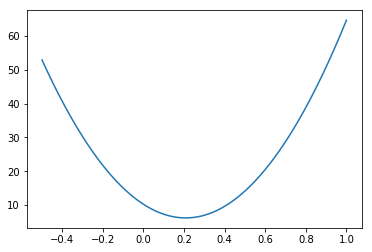

In [193]:

datav_filename1 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_nz_weight_nbins10_jk100_k1.txt'
datav_filename2 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_nz_weight_nbins10_jk100_k2.txt'
datav_filename3 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_nz_weight_nbins10_jk100_k3.txt'
datav_filename4 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_nz_weight_nbins10_jk100_k4.txt'
bestfit_A1, errA1, _ = fitting_chisquare_cmass(1, modelv_interp, datav_filename=datav_filename1)
bestfit_A2, errA2, _  = fitting_chisquare_cmass(2, modelv_interp, datav_filename=datav_filename2)
bestfit_A3, errA3, _  = fitting_chisquare_cmass(3, modelv_interp, datav_filename=datav_filename3)
bestfit_A4, errA4, _  = fitting_chisquare_cmass(4, modelv_interp, datav_filename=datav_filename4)
bestfit_A = [bestfit_A1, bestfit_A2, bestfit_A3, bestfit_A4 ]
errA = [errA1,errA2,errA3,errA4]


1.7970795790409793
A1, Abest, A2 0.1983239664793296 0.6372627452549051 1.0
bestfit A= 0.6373 errA=0.4389  chi2= 1.7970795790409793
2.3772570008664324
A1, Abest, A2 -0.2975559511190224 -0.008020160403208076 0.2814856297125943
bestfit A= -0.0080 errA=0.2895  chi2= 2.3772570008664324
6.033866977422126
A1, Abest, A2 -0.2083041660833217 -0.07120142402848056 0.06593131862637247
bestfit A= -0.0712 errA=0.1371  chi2= 6.033866977422126
3.8266005446525595
A1, Abest, A2 -0.11779235584711695 0.04505090101802034 0.2079241584831697
bestfit A= 0.0451 errA=0.1628  chi2= 3.8266005446525595


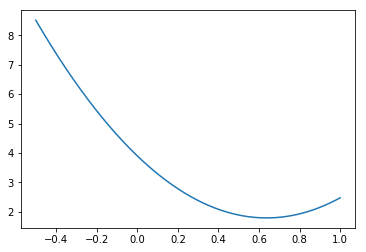

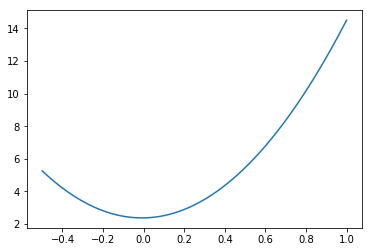

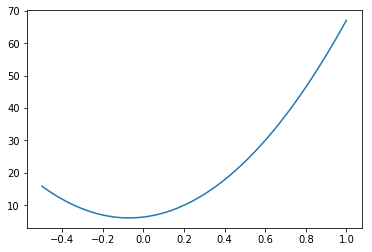

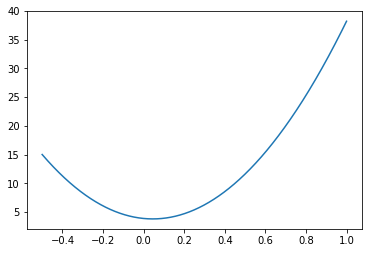

In [188]:

datav_filename1 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_jk100_k1.txt'
datav_filename2 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_jk100_k2.txt'
datav_filename3 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_jk100_k3.txt'
datav_filename4 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_jk100_k4.txt'
bestfit_Ad1, errAd1, _ = fitting_chisquare_cmass(1, modelv_interp, datav_filename=datav_filename1)
bestfit_Ad2, errAd2, _  = fitting_chisquare_cmass(2, modelv_interp, datav_filename=datav_filename2)
bestfit_Ad3, errAd3, _  = fitting_chisquare_cmass(3, modelv_interp, datav_filename=datav_filename3)
bestfit_Ad4, errAd4, _  = fitting_chisquare_cmass(4, modelv_interp, datav_filename=datav_filename4)
bestfit_Ad = [bestfit_Ad1, bestfit_Ad2, bestfit_Ad3, bestfit_Ad4 ]
errA = [errAd1,errAd2,errAd3,errAd4]


In [207]:
xi2

array([-0.05519437,  0.05982881,  0.05115721,  0.05723435,  0.04905705,
       -0.00022301,  0.00023494,  0.02308556,  0.01452623,  0.01606397,
        0.01594832,  0.0118027 ,  0.00743268,  0.00773126,  0.00667993,
        0.00476949,  0.00267788,  0.00022303,  0.00178301,  0.00325351])

In [211]:
nz_ratio = [1.0220067305853204 ,
0.9927056073181553 ,
1.0616888743151736 ,
0.9791476322482378 ,
1.0691287782572456 ,
1.0918538783927694 ,
1.07618823087704 ,
1.1051097962799177 ,
1.1335429663292678 ,
1.1554185399000843 ,
1.1736589080344904 ,
1.1855614192219777 ,
1.142186499711714 ,
1.1300927640740897 ,
1.1208257687928838 ,
1.1067326748626392 ,
1.0983534313154368 ,
1.071694918773354 ,
0.9633961414552016 ,
0.9281756892573679]
nz_ratio = np.array(nz_ratio)

25.866502430182774
A1, Abest, A2 -0.05713114262285246 -0.013510270205404129 0.030140602812056216
bestfit A= -0.0135 errA=0.0436  chi2= 25.866502430182774
15.77285324154656
A1, Abest, A2 0.15344306886137726 0.30932618652373045 0.46523930478609576
bestfit A= 0.3093 errA=0.1559  chi2= 15.77285324154656
True
7.946269417668903e-06 0.0045234085781923105
0.0017566994624315963
None


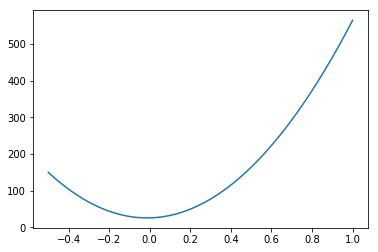

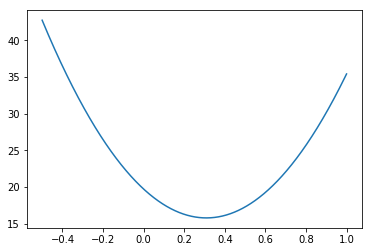

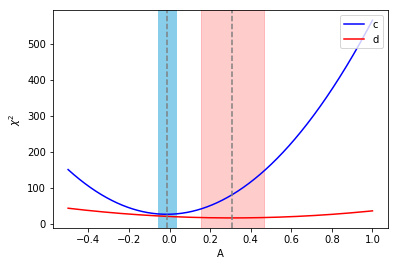

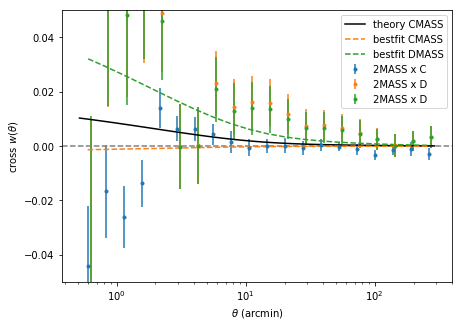

In [214]:

#datav_filename = '../data_txt//acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_nbins10_jk100.txt'
datav_filename1 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_noz_weight_nbins10_broad_jk100.txt'
bestfit_A_1bin, errA, chisquare_cmass = fitting_chisquare_cmass(0, modelv_1bin_interp, datav_filename=datav_filename1)

#datav_filename = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_k_jk100.txt'
datav_filename2 = '../data_txt//acf_cross_2mass_x_dmass_spt_bweight_nbins10_broad_jk100.txt'
bestfit_Ad_1bin, errAd, chisquare_cmass_d = fitting_chisquare_cmass(0, modelv_1bin_interp, datav_filename=datav_filename2)


fig, ax = plt.subplots()

#Ass = np.linspace(0.8, 1.0, 50000)
Ass = np.linspace(-0.5, 1.0, 50000)

ax.plot(Ass, chisquare_cmass, '-b', label='c')
ax.plot(Ass, chisquare_cmass_d, '-r',label='d')
#ax.plot(Ass, chisqr_result_sd, '-g',label='S-d')

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
ax.axvspan(bestfit_A_1bin- errA, bestfit_A_1bin + errA, alpha=0.99, color='skyblue')
ax.axvspan(bestfit_Ad_1bin- errAd, bestfit_Ad_1bin+ errAd,alpha=0.2, color='red')

ax.axvline(x=bestfit_A_1bin, color = 'grey', ls='--')
ax.axvline(x=bestfit_Ad_1bin, color = 'grey', ls='--')

ax.set_xlabel(r'A')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)




fig, ax = plt.subplots(figsize = (7,5))

meanr, xi, xi_err = np.loadtxt(datav_filename1, unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(datav_filename2, unpack=True)

cov = np.loadtxt(datav_filename1.split('.txt')[0]+'.cov')
cov2 =  np.loadtxt(datav_filename2.split('.txt')[0]+'.cov')
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)


print is_pos_def(cov2)
print eigenstats(cov2)
    
wprojA = modelv_1bin_interp[0](meanr, bestfit_A_1bin)
wprojAd = modelv_1bin_interp[0](meanr2, bestfit_Ad_1bin)

wprojA_test01 = modelv_1bin_interp[0](meanr, 0.1)
wprojA_test02 = modelv_1bin_interp[0](meanr, 0.2)

DAT = np.column_stack(( meanr, wprojA ))
np.savetxt(datav_filename1.split('.txt')[0] + '.theory', DAT, header = 'meanr xi')

DAT = np.column_stack(( meanr2, wprojAd ))
np.savetxt(datav_filename2.split('.txt')[0]+ '.theory', DAT, header = 'meanr xi')

ax.axhline(y=0, color='grey', linestyle='--')
ax.semilogx(theta*60, wproj_1bin,'-k', label = 'theory CMASS')
#ax.semilogx(theta*60, wprojA_test01,'-m', label = 'theory model A=0.1')
#ax.semilogx(theta*60, wprojA_test02,'--m', label = 'theory model A=0.2')
ax.errorbar(meanr*60, xi, yerr = xi_err, fmt = '.', label='2MASS x C')
ax.errorbar(meanr2*60*1.05, xi2, yerr = xi_err2, fmt = '.', label='2MASS x D')
ax.errorbar(meanr2*60*1.05, xi2/nz_ratio, yerr = xi_err2, fmt = '.', label='2MASS x D')
ax.semilogx(meanr*60, wprojA,'--', color = ax.lines[-2].get_color(), label = 'bestfit CMASS')
ax.semilogx(meanr2*60, wprojAd,'--', color = ax.lines[-2].get_color(), label = 'bestfit DMASS')

#ax.text(20, -0.002, r'$A_c$={:0.3f}  $A_d$={:0.3f}'.format(bestfit_A_1bin, bestfit_Ad_1bin), fontsize = 15)
#ax.text(20, -0.003, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA, errAd), fontsize = 15)
#ax.text(20, -0.0045, r'$12 < K_{20} < 14$', fontsize = 15)

ax.set_ylim(-0.05, 0.05)
#ax.set_xlim(2.5, 250)
ax.set_xlabel(r'$\theta$ (arcmin)')
ax.set_ylabel(r'cross $w(\theta)$')
ax.legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)

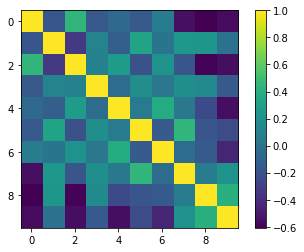

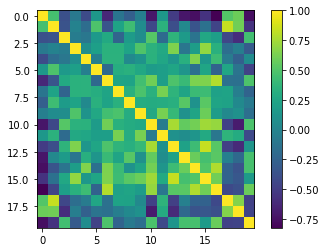

In [208]:
fig, ax = plt.subplots()
im = ax.imshow( np.corrcoef(cov) )
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow( np.corrcoef(cov2) )
fig.colorbar(im, ax=ax)

In [50]:
ls ../data_txt/acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_no_bweight_nbins10_jk100.txt

../data_txt/acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_no_bweight_nbins10_jk100.txt


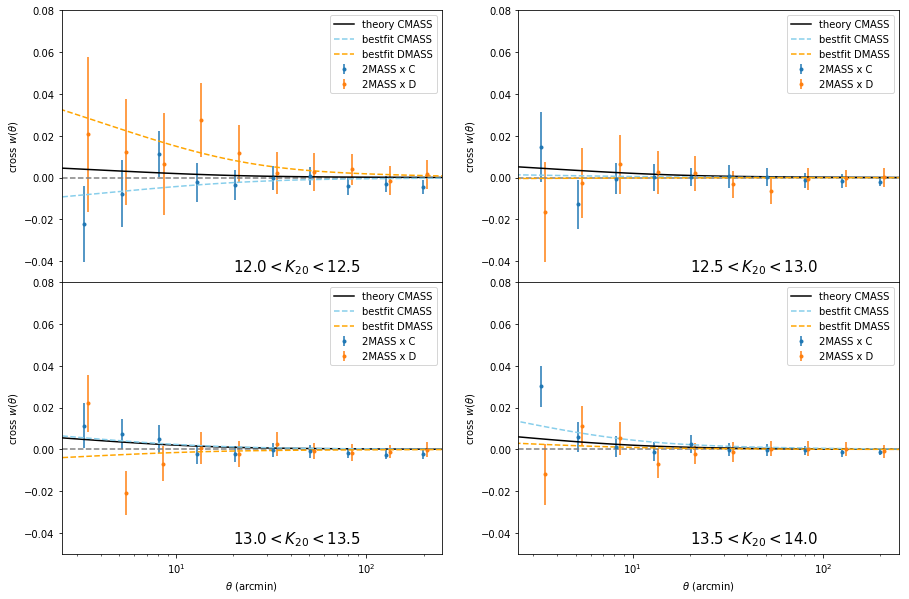

In [198]:

label = [r'$12.0 < K_{20} < 12.5$', r'$12.5 < K_{20} < 13.0$',\
         r'$13.0 < K_{20} < 13.5$', r'$13.5 < K_{20} < 14.0$']

wproj = [wproj1,wproj2,wproj3,wproj4 ]

fig, ax = plt.subplots(2, 2, figsize = (15,10))
ax = ax.ravel()
for i in range(1, 5):
    
    dat1 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_nz_weight_nbins10_jk100_k{}'.format(i)
    #dat1 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_jk100_k{}'.format(i)
    dat2 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_jk100_k{}'.format(i)
    
    meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
    meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)
    
    cov = np.loadtxt(dat1+'.cov')
    cov2 =  np.loadtxt(dat2+'.cov')
    
    wprojA = modelv_interp[i](theta, bestfit_A[i-1])
    wprojAd = modelv_interp[i](theta, bestfit_Ad[i-1])
    
    ax[i-1].axhline(y=0, color='grey', linestyle='--')
    ax[i-1].semilogx(theta*60, wproj[i-1],'k-', label = 'theory CMASS')
    ax[i-1].errorbar(meanr*60, xi, yerr = xi_err, fmt = '.', label='2MASS x C')
    ax[i-1].errorbar(meanr2*60*1.05, xi2, yerr = xi_err2, fmt = '.', label='2MASS x D')
    ax[i-1].semilogx(theta*60, wprojA,'--', color = 'skyblue', label = 'bestfit CMASS')
    ax[i-1].semilogx(theta*60, wprojAd,'--', color = 'orange', label = 'bestfit DMASS')
    
    #ax[i-1].text(20, -0.02, r'$A_c$={:0.3f}  $A_d$={:0.3f}'.format(bestfit_A[i-1], bestfit_Ad[i-1]), fontsize = 15)
    #ax[i-1].text(20, -0.03, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA[i-1], errAd[i-1]), fontsize = 15)
    
    #ax[i-1].text(20, -0.03, r'$A_d$={:0.3f},  $errA_d$={:0.3f}'.format(bestfit_Ad[i-1], errAd[i-1]), fontsize = 15)
    #ax[i-1].text(20, -0.03, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA[i-1], errAd[i-1]), fontsize = 15)
    
    ax[i-1].text(20, -0.045, label[i-1], fontsize = 1 5)

    ax[i-1].  set_ylim(-0.05, 0.08)
    ax[i-1].set_xlim(2.5, 250)
    ax[i-1].set_xlabel(r'$\theta$ (arcmin)')
    ax[i-1].set_ylabel(r'cross $w(\theta)$')
    ax[i-1].legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)

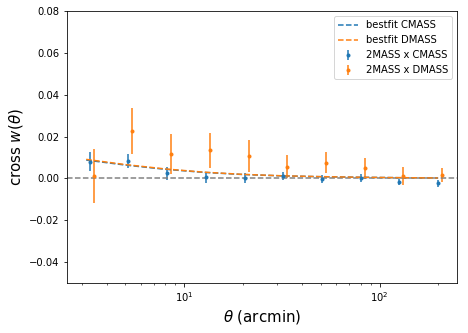

In [158]:

fig, ax = plt.subplots(figsize = (7,5))


#dat1 = '../data_txt//acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_nbins10_jk100'
#dat2 = '../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_k_jk100'

dat1 = '../data_txt//acf_cross_2mass_x_cmass_ngc_sys_cp_noz_weight_no_bweight_nbins10_jk100'
dat2 ='../data_txt//acf_cross_2mass_x_dmass_spt_no_bweight_wrong_mask_nbins10_jk100'
#dat1 ='../data_txt//acf_cross_2mass_x_dmass_spt_nbins10_k_jk100'
meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)

HF = 0.88888888
cov = np.loadtxt(dat1+'.cov')
cov2 =  np.loadtxt(dat2+'.cov')
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)



wprojA = modelv_1bin_interp[0](meanr, bestfit_A_1bin)
wprojAd = modelv_1bin_interp[0](meanr2, bestfit_Ad_1bin)

wprojA_test = modelv_1bin_interp[0](meanr, 0.1)

DAT = np.column_stack(( meanr, wprojA ))
np.savetxt(dat1 + '.theory', DAT, header = 'meanr xi')

DAT = np.column_stack(( meanr2, wprojAd ))
np.savetxt(dat2 + '.theory', DAT, header = 'meanr xi')

ax.axhline(y=0, color='grey', linestyle='--')
ax.errorbar(meanr*60, xi, yerr = xi_err, fmt = '.', label='2MASS x CMASS')
ax.errorbar(meanr2*60*1.05, xi2, yerr = xi_err2, fmt = '.', label='2MASS x DMASS')
ax.semilogx(theta*60, wprojA,'--', color = ax.lines[-2].get_color(), label = 'bestfit CMASS')
ax.semilogx(theta*60, wprojAd,'--', color = ax.lines[-2].get_color(), label = 'bestfit DMASS')

#ax.text(20, -0.002, r'$A_c$={:0.3f}  $A_d$={:0.3f}'.format(bestfit_A_1bin, bestfit_Ad_1bin), fontsize = 15)
#ax.text(20, -0.003, r'$err A_c$={:0.3f}  $err A_d$={:0.3f}'.format(errA, errAd), fontsize = 15)
#ax.text(20, -0.0045, r'$12 < K_{20} < 14$', fontsize = 15)

#ax.set_ylim(-0.01, 0.01)
ax[.set_ylim(-0.05, 0.08)
ax.set_xscale('log')
ax.set_xlim(2.5, 250)
ax.set_xlabel(r'$\theta$ (arcmin)', fontsize = 15)
ax.set_ylabel(r'cross $w(\theta)$', fontsize = 15)
ax.legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)